<a href="https://colab.research.google.com/github/ronald-hk-chung/ssnotebook/blob/main/computer_vision/activation_map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generating CAMs (Class Activation Maps) for image classification problems

**Mission Statement**

1. Understanding Transfer Learning for image data
2. Build a simple dog/cat classifier
3. Generating Class Activation Maps for image classification problems

## Notebook Preperation

In [1]:
!pip install -q git+https://github.com/ronald-hk-chung/sstorch.git
!pip install -q duckduckgo_search

from sstorch.learner import SSTLearner
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torchinfo

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 57.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 20.3 MB/s eta 0:00:00


## Transfer Learning with Image data

Transfer learning is a technique in machine learning in which knowledge learned from a task is re-used in order to boost performance on a related task. It is a popular approach in deep learning where pre-trained models are used as the starting point on computer vision and natural language processing tasks given the vast compute and time resources required to develop neural network models on these problems.

For image classification, it is common to use a deep learning model pre-trained for a large and challenging image classification task such as the ImageNet 1000-class photograph classification. The research organization that develop models fo this competition and do well often release their final model under a permissive license for reuse. Thse model can take days or weeks to train on modern hardware.

In PyTorch, the [`torchvision.models`](https://pytorch.org/vision/stable/models.html) subpackage contains definitions of models for addressing different tasks, including image classification

## Download Custom Images - Dogs vs Cats

We will use duckduckgo-search to download Dogs vs Cats images.

In [2]:
import requests
import uuid
from duckduckgo_search import DDGS
from pathlib import Path
from PIL import Image
from tqdm.auto import tqdm

#Create datapath
data_path = Path('data')
(data_path / 'dogs').mkdir(parents=True, exist_ok=True)
(data_path / 'cats').mkdir(parents=True, exist_ok=True)

# Get URL to download images
dog_searches = DDGS().images(keywords='dogs',
                            max_results=300)

cat_searches = DDGS().images(keywords='cats',
                            max_results=300)

# Download data
for search in tqdm(dog_searches):
    try:
        im = Image.open(requests.get(search['image'], stream=True, timeout=5).raw).convert('RGB')
        im.save(f'data/dogs/{str(uuid.uuid4())}.jpg')
    except:
        pass

for search in tqdm(cat_searches):
    try:
        im = Image.open(requests.get(search['image'], stream=True, timeout=5).raw).convert('RGB')
        im.save(f'data/cats/{str(uuid.uuid4())}.jpg')
    except:
        pass

print(f"Total of Dog Images: {len(list(Path('data/dogs').glob('*.jpg')))}")
print(f"Total of Cat Images: {len(list(Path('data/cats').glob('*.jpg')))}")

  0%|          | 0/291 [00:00<?, ?it/s]

  0%|          | 0/285 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


Total of Dog Images: 201
Total of Cat Images: 223


## Prepare dataset and dataloaders with pretrained_transformation

In order to prepare our data to run through the pre-trained ResNet-34. Below steps are conducted:

1. Resize to (3, 224, 224)
2. Normalised with mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]

In [52]:
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

# Create dataframe for images
df = pd.DataFrame(list(data_path.rglob('*.jpg')), columns=['path'])
df['class_names'] = df['path'].apply(lambda x: x.parent.name)
class_names = list(set(df['class_names']))
df['classes'] = df['class_names'].apply(lambda x: [float(class_name == x) for class_name in class_names])
df_train, df_valid = train_test_split(df, test_size=0.2)

# Get Resnet34 pretrained weights
weights = torchvision.models.get_weight("ResNet34_Weights.IMAGENET1K_V1")

tfms = weights.transforms()
print(tfms)

rtfms = T.Compose([
    T.Normalize(mean=[0.0] * 3,
                std = list(map(lambda x: 1/x, tfms.std))),
    T.Normalize(mean=list(map(lambda x: -x, tfms.mean)),
                std=[1.0] * 3),
    T.ToPILImage()
])

# Dataset for images
class DGDataset(Dataset):
  def __init__(self, df, tfms):
    self.df = df
    self.tfms = tfms
  def __len__(self):
    return len(self.df)
  def __getitem__(self, idx):
    img = self.tfms(Image.open(self.df.iloc[idx].path))
    label = torch.tensor(self.df.iloc[idx].classes, dtype=torch.float32)
    return img, label


train_ds = DGDataset(df=df_train,
                     tfms=tfms)

valid_ds = DGDataset(df=df_valid,
                     tfms=tfms)

train_dl = DataLoader(dataset=train_ds,
                      batch_size=16,
                      shuffle=True,
                      pin_memory=True,
                      drop_last=True)

valid_dl = DataLoader(dataset=valid_ds,
                      batch_size=16,
                      shuffle=False,
                      pin_memory=True,
                      drop_last=True)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


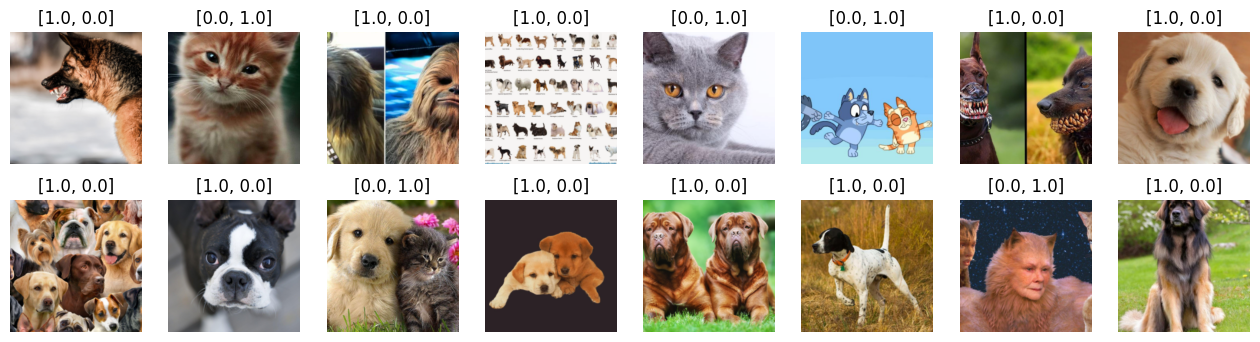

In [53]:
images, labels = next(iter(train_dl))

fig = plt.figure(figsize=(16, 4))
rows, cols = 2, 8
for i, image in enumerate(images):
    plt.subplot(rows, cols, i+1)
    plt.imshow(rtfms(image))
    plt.title(labels[i].tolist())
    plt.axis(False)

## Visualize one batch of data

# Prepare for Pretrained model

**Downloading Pre-trained model**

We will use pre-trained resnet34 as a backbone of our classification problem

In [54]:
import torch
from torchvision.models import resnet34, ResNet34_Weights

model = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)

**Replacing the head of model**
The 'head' of the model (fc layer in resnet case) usually is belongs to its classifier part. The featurizer part is usually left untouched in transfer learning as we try to leverage the model's ability to generate features for us.

We will replace the fc layer accordingly to the classes needed.

In [55]:
import torch.nn as nn

class Classifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.classifier = nn.Sequential(nn.Linear(512, 128),
                                    nn.ReLU(),
                                    nn.BatchNorm1d(128),
                                    nn.Dropout(0.4),
                                    nn.Linear(128, 32),
                                    nn.ReLU(),
                                    nn.BatchNorm1d(32),
                                    nn.Dropout(0.4),
                                    nn.Linear(32, 2),
                                    nn.Sigmoid())

  def forward(self, X):
    X = self.classifier(X).squeeze()
    return X

model.fc = Classifier()

In [27]:
y_logits = model(images)

**Creating a Learner Class**

We will use `sstorch` to create a learner class for training

In [56]:
from sklearn.metrics import accuracy_score
from torch.nn.functional import binary_cross_entropy_with_logits

def metric_fn(y_logits, y):
    y_preds = np.round(y_logits.detach().cpu().numpy())
    y = y.detach().cpu().numpy()
    accuracy = (y_preds == y).transpose().sum(axis=1)/y.shape[0]
    return {'accuracy': accuracy}

loss_fn = nn.BCELoss()

optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)

learner = SSTLearner(model=model,
                     loss_fn=loss_fn,
                     metric_fn=metric_fn,
                     optimizer=optimizer,
                     train_dataloader=train_dl,
                     valid_dataloader=valid_dl)

**Model Freezing**

We will need to *freeze* the featurizer of the model and only train the head of the model. This is done by using the `param.requires_grad=False`. In `sstorch`, we can use `freeze()`

In [57]:
learner.freeze()
learner.unfreeze(layers=['fc'])

**Checking the model summary**

In [58]:
learner.model_info()

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [16, 3, 224, 224]    [16, 2]              --                   Partial
├─Conv2d (conv1)                         [16, 3, 224, 224]    [16, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [16, 64, 112, 112]   [16, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [16, 64, 112, 112]   [16, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [16, 64, 112, 112]   [16, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [16, 64, 56, 56]     [16, 64, 56, 56]     --                   False
│    └─BasicBlock (0)                    [16, 64, 56, 56]     [16, 64, 56, 56]     --                   False
│    │    └─Conv2d (conv1)               [16, 64, 56, 56]     [16, 64, 56, 56]     (36,864)             False
│    │    

In [59]:
learner.train(10)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | LR: 1.0E-03 | train_loss: 0.555 | valid_loss: 0.411 
train_metric: {'accuracy': array([0.664, 0.741])}
valid_metric: {'accuracy': array([0.962, 0.95 ])}
----------------------------------------------------------------------------------------------------
Epoch: 2 | LR: 1.0E-03 | train_loss: 0.35 | valid_loss: 0.272 
train_metric: {'accuracy': array([0.899, 0.905])}
valid_metric: {'accuracy': array([0.95 , 0.975])}
----------------------------------------------------------------------------------------------------
Epoch: 3 | LR: 1.0E-03 | train_loss: 0.267 | valid_loss: 0.229 
train_metric: {'accuracy': array([0.946, 0.923])}
valid_metric: {'accuracy': array([0.975, 0.975])}
----------------------------------------------------------------------------------------------------
Epoch: 4 | LR: 1.0E-03 | train_loss: 0.21 | valid_loss: 0.185 
train_metric: {'accuracy': array([0.946, 0.943])}
valid_metric: {'accuracy': array([0.988, 0.988])}
-------------------------------------------

## Generating CAMs (Class Activation Maps) for image classification problems

1. Decide for which class you want to calculate the CAM and for which convolutional layer in the neural network you want to compute the CAM
2. Calculate the activations arising from any convolutional layers - lets say the feature shape at a random convolution layer is 512x7x7
3. Fetch the gradient values arising from this layer wiht repect to the class of interest. The output gradient shape is 256x512x3x3 (which is the shape of the convolutional tensor - that is , in-channels x out-channels x kernel-size x kernel size
4. Compute the mean of the gradients wihtin each output channel. the output shape is 512
5. Calculate the weighted activation map - which is the muliplication of 512 gradient means by the 512 activation channels. The output shape is 512x7x7
6. Compute the mean (across 512 channels) of the weighted activation map to fetch an output of the shape 7x7
7. Resize (upscale) the weighted activation map outputs to fetch an image of a size that is of the same size as the input. This is done so that we have an activation map that resembles the original image.
8. Overlay the weighted activation map onto the input image

The key to the entire process lies in step 5. We consider two aspects of the step:
* If a certain pixel is important, then the CNN will have a large activation at those pixels
* If a certain convolutional channel is important with respect to the required class, the gradients at that channel will be very large

Multiplying these two, we will end up with a map of importance across all the pixels

In [62]:
import torch
from torchvision.transforms.functional import to_pil_image
from torchvision import transforms
from torchvision.transforms import v2 as T
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import colormaps
from typing import Callable
import numpy as np

def get_cam(img_path: str,
            tfms: T.Compose,
            rtfms: T.Compose,
            classifier: Callable,
            layers_to_activate: list,
            class_to_activate: int):
    """
    Method to get Class Activation Maps(CAM) for in image

    Args:
        img_path (str):   path of img to be analysed
        tfms (transforms): transform of image, PIL to Tensor
        rtfms (transforms): reverse transform of image, Tensor to PIL
        classifier (SSTLearner): SSTLearner class classifier
        layers_to_activate (list): layers to get activation from model in classifier
        class_to_activate (int): class for Class Activation Maps (CAM) analysis
    """

    gradients = None
    activations = None

    def backward_hook(module, grad_input, grad_output):
        nonlocal gradients
        gradients = grad_output

    def forward_hook(module, args, output):
        nonlocal activations
        activations = output

    # unfreeze layers and attach hooks to layers_to_activate
    classifier.unfreeze()
    classifier.attach_forward_hooks(layers_to_activate, forward_hook)
    classifier.attach_backward_hooks(layers_to_activate, backward_hook)

    # Open image and perform forward and backward pass on class to activates
    img = tfms(Image.open(img_path).convert("RGB"))
    y_logits = classifier.model(img.unsqueeze(dim=0).to("cuda"))
    print(f"Prediction: {y_logits}")
    y_logits[class_to_activate].backward()

    # freeze classifier and remove hooks
    classifier.remove_hooks()
    classifier.freeze()

    # Calculate gradient heatmap
    pooled_gradients = torch.mean(gradients[0], dim=[0, 2, 3])
    for i in range(activations.size()[1]):
        activations[:, i, ::] *= pooled_gradients[i]
    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = torch.nn.functional.relu(heatmap)
    heatmap /= torch.max(heatmap)

    # Plot out original image and image with heatmap
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(rtfms(img))
    ax1.axis(False)
    overlay = to_pil_image(heatmap.detach(), mode="F").resize(
        (img.shape[1], img.shape[2]), resample=Image.BICUBIC
    )
    cmap = colormaps["jet"]
    overlay = (255 * cmap(np.asarray(overlay) ** 2)[:, :, :3]).astype(np.uint8)
    ax2.imshow(rtfms(img))
    ax2.imshow(overlay, alpha=0.4, interpolation="nearest")
    ax2.axis(False)
    plt.show()

In [63]:
url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQCTe9GtB0Sf0X4zKtb_gtr4s0gbJZkczzCMOfpl8PtSCcAZE8dfMPHmw4DNRaGFC_Ut8Y&usqp=CAU'
with open('test.jpg', 'wb') as f:
  f.write(requests.get(url).content)

Prediction: tensor([0.9672, 0.0271], device='cuda:0', grad_fn=<SqueezeBackward0>)


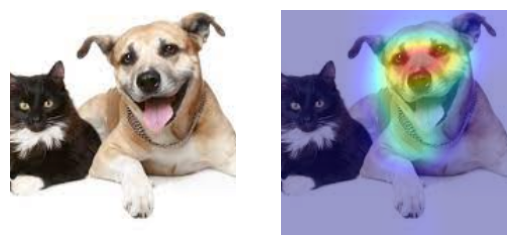

In [64]:
# Getting CAM for class 0 Dogs
get_cam(img_path='test.jpg',
        tfms=tfms,
        rtfms=rtfms,
        classifier=learner,
        layers_to_activate=['layer4.2'],
        class_to_activate=0)

Prediction: tensor([0.9672, 0.0271], device='cuda:0', grad_fn=<SqueezeBackward0>)


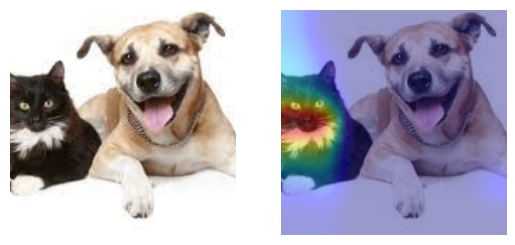

In [66]:
# Getting CAM for class 1 Cats
get_cam(img_path='test.jpg',
        tfms=tfms,
        rtfms=rtfms,
        classifier=learner,
        layers_to_activate=['layer4.2'],
        class_to_activate=1)